In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
%matplotlib inline

path = '/Users/chris/Desktop/mastrangelo/'


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

k = pd.Series([833, 134, 38, 15, 5, 0])

In [3]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

Read in and process data (pad and create zero bins)

In [4]:
truth = pd.read_csv(path+'collect_ground_truth.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.read_csv(path+'collect_recovery.csv', converters=dict(transit_multiplicities=literal_eval))


#### Quality control

With so many records, some of them get corrupted. There are several ways we can deal with this, but since each model has 30 random samples, a corrupted record will simply be dropped. Therefore, later on, rather than summing to marginalize the log likelihoods, we take the mean. 

In [46]:
# retrieve indices of rows that somehow got padded with many extra bins
long_indices = recovery.loc[recovery['transit_multiplicities'].str.len() > 6]['transit_multiplicities'].index

# drop these rows
recovery = recovery.drop(long_indices)

In [5]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

In [6]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


Prepare machinery for injection-recovery experiments

In [6]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-1,0,6)[gi_m] 
    cube[1] = np.linspace(0,1,11)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [7]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

What would it look like to take the logL of something that's sqrt(N) deviated from the ground truth, where N is the number of systems in each bin? 

Answer: this is $\Delta$ logL of 3 different from the perfect case of comparing the ground truth to itself.

In [8]:
better_loglike(np.array([9900, 804, 122, 32, 11, 3, 0]), np.array([1e4, 833, 134, 38, 15, 5, 0]))

-23.261564101898227

#### Model 2: m = -1, b = 0.5, c = 4e9, f = 0.3 (heavy sculpting model)

In [9]:
tm_fiducial = truth.loc[(truth.ms == -1.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

692    [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]
Name: transit_multiplicities, dtype: object

In [10]:
test_recovery = recovery.loc[(recovery.ms == -1.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]


Let's quickly check their transit yields to see whether they make sense.

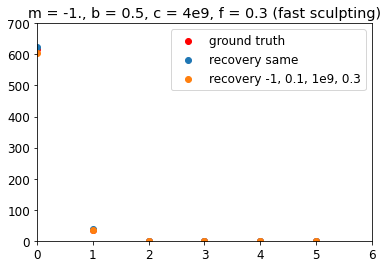

In [11]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[20760].transit_multiplicities)), recovery.iloc[20760].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

This makes sense: the yields between higher b but short-lived sculpting and lower b but longer-lived sculpting are similar.

In [96]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep best logL for each model
                    best_logL = np.max(logLs)
                    best_arg = np.argmax(logLs)
                    all_logLs.append(best_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[best_arg])

                except:
                    all_logLs.append(0.)
                

In [74]:
better_loglike([1886.4, 126.0, 0.0, 0.0, 0.0, 0.0], np.sum(tm_fiducial))

-633.6779361352512

In [75]:
better_loglike(tm_recovery[i], np.sum(tm_fiducial))

-2924.6370860174347

In [97]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'injection_transit_multiplicities': all_transit_multiplicities, 
                            'injection_logL': all_logLs})
model_logLs

,m,b,c,f,injection_transit_multiplicities,injection_logL
0,-1.0,0.0,1.000000e+08,0.1,"[210.8, 13.0, 0.0, 0.0, 0.0, 0.0]",-275.189746
1,-1.0,0.0,1.000000e+08,0.2,"[421.6, 26.0, 0.0, 0.0, 0.0, 0.0]",-47.542987
2,-1.0,0.0,1.000000e+08,0.3,"[612.9, 35.4, 0.0, 0.0, 0.0, 0.0]",-6.842910
3,-1.0,0.0,1.000000e+08,0.4,"[787.2, 51.6, 0.0, 0.0, 0.0, 0.0]",-29.931965
4,-1.0,0.0,1.000000e+08,0.5,"[984.0, 64.5, 0.0, 0.0, 0.0, 0.0]",-94.298570
...,...,...,...,...,...,...
7255,0.0,1.0,1.000000e+10,0.6,"[1423.2, 677.4, 333.0, 135.6, 36.6, 6.0]",-1348.251547
7256,0.0,1.0,1.000000e+10,0.7,"[1660.3999999999999, 790.3, 388.5, 158.2, 42.6...",-1683.153209
7257,0.0,1.0,1.000000e+10,0.8,"[1897.6000000000001, 903.2, 444.0, 180.8, 48.8...",-2031.484213
7258,0.0,1.0,1.000000e+10,0.9,"[2134.8, 1016.1, 499.5, 203.4, 54.9, 9.0]",-2390.072122


### Note that while these logLs take f into account, they do not take the zero-bin into account. analyze.ipynb has machinery to handle that, and we can do this injection-recovery routine with those logLs instead, if we want. 

#### What is the $\Delta$ logL between the very best model and the ground truth?

Identify best and good models

In [77]:
x = np.logspace(8, 10, 1000)

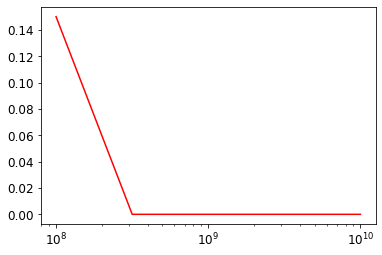

In [80]:
ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
plt.xscale('log')


In [85]:
model_logLs.iloc[1492]

m                -8.000000e-01
b                 2.000000e-01
c                 1.584893e+09
f                 3.000000e-01
injection_logL   -6.827245e+00
Name: 1492, dtype: float64

In [98]:
best_logL = max(model_logLs.loc[model_logLs.injection_logL < 0.].injection_logL)
print("Best model: ", model_logLs.loc[(model_logLs.injection_logL >= best_logL) & (model_logLs.injection_logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.injection_logL)
delta_logL = best_logL - model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)].injection_logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.injection_logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f   injection_transit_multiplicities  \
1382 -0.8  0.1  1.584893e+09  0.3  [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]   
1492 -0.8  0.2  1.584893e+09  0.3  [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]   
3752 -0.4  0.1  1.584893e+08  0.3  [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]   
3842 -0.4  0.1  1.000000e+10  0.3  [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]   

      injection_logL  
1382       -6.827245  
1492       -6.827245  
3752       -6.827245  
3842       -6.827245  
Ground truth:  632   -6.837797
Name: injection_logL, dtype: float64
Some models between best model and ground truth: 
      m    b             c    f  \
12 -1.0  0.0  1.584893e+08  0.3   
52 -1.0  0.0  1.000000e+09  0.3   
72 -1.0  0.0  2.511886e+09  0.3   
82 -1.0  0.0  3.981072e+09  0.3   
92 -1.0  0.0  6.309573e+09  0.3   

                 injection_transit_multiplicities  injection_logL  
12  [617.6999999999999, 34.5, 0.0, 0.0, 0.0, 0.0]       -6.829712  
52              [613.5, 34.5, 0.0, 0.0, 0.0, 0

Hold on: why are there many best models? 

In [105]:
model_logLs.iloc[1490:1500]

,m,b,c,f,injection_transit_multiplicities,injection_logL
1490,-0.8,0.2,1.584893e+09,0.1,"[214.8, 11.700000000000001, 0.1, 0.1, 0.0, 0.0]",-270.167605
1491,-0.8,0.2,1.584893e+09,0.2,"[429.6, 23.400000000000002, 0.2, 0.2, 0.0, 0.0]",-45.420846
1492,-0.8,0.2,1.584893e+09,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
1493,-0.8,0.2,1.584893e+09,0.4,"[780.0, 50.0, 0.4, 0.4, 0.0, 0.0]",-28.692784
1494,-0.8,0.2,1.584893e+09,0.5,"[975.0, 62.5, 0.5, 0.5, 0.0, 0.0]",-91.059389
1495,-0.8,0.2,1.584893e+09,0.6,"[1170.0, 75.0, 0.6, 0.6, 0.0, 0.0]",-180.013359
1496,-0.8,0.2,1.584893e+09,0.7,"[1365.0, 87.5, 0.7, 0.7, 0.0, 0.0]",-287.315021
1497,-0.8,0.2,1.584893e+09,0.8,"[1560.0, 100.0, 0.8, 0.8, 0.0, 0.0]",-408.046025
1498,-0.8,0.2,1.584893e+09,0.9,"[1755.0, 112.5, 0.9, 0.9, 0.0, 0.0]",-539.033934
1499,-0.8,0.2,1.584893e+09,1.0,"[1950.0, 125.0, 1.0, 1.0, 0.0, 0.0]",-678.112630


In [106]:
model_logLs.iloc[1380:1390]

,m,b,c,f,injection_transit_multiplicities,injection_logL
1380,-0.8,0.1,1.584893e+09,0.1,"[214.20000000000002, 11.3, 0.0, 0.0, 0.0, 0.0]",-271.902638
1381,-0.8,0.1,1.584893e+09,0.2,"[428.40000000000003, 22.6, 0.0, 0.0, 0.0, 0.0]",-45.955880
1382,-0.8,0.1,1.584893e+09,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
1383,-0.8,0.1,1.584893e+09,0.4,"[778.4000000000001, 38.400000000000006, 0.0, 0...",-25.144699
1384,-0.8,0.1,1.584893e+09,0.5,"[973.0, 48.0, 0.0, 0.0, 0.0, 0.0]",-84.011304
1385,-0.8,0.1,1.584893e+09,0.6,"[1167.6, 57.599999999999994, 0.0, 0.0, 0.0, 0.0]",-169.465274
1386,-0.8,0.1,1.584893e+09,0.7,"[1362.1999999999998, 67.19999999999999, 0.0, 0...",-273.266936
1387,-0.8,0.1,1.584893e+09,0.8,"[1556.8000000000002, 76.80000000000001, 0.0, 0...",-390.497940
1388,-0.8,0.1,1.584893e+09,0.9,"[1751.4, 86.4, 0.0, 0.0, 0.0, 0.0]",-517.985849
1389,-0.8,0.1,1.584893e+09,1.0,"[1946.0, 96.0, 0.0, 0.0, 0.0, 0.0]",-653.564545


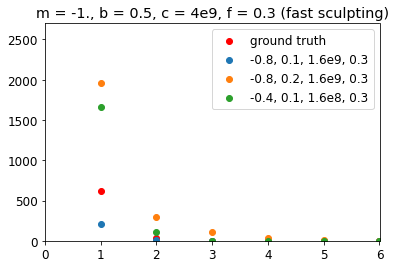

In [213]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[6909].transit_multiplicities)), recovery.iloc[6909].transit_multiplicities, label='-0.8, 0.1, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[7459].transit_multiplicities)), recovery.iloc[7459].transit_multiplicities, label='-0.8, 0.2, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[18759].transit_multiplicities)), recovery.iloc[18759].transit_multiplicities, label='-0.4, 0.1, 1.6e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,2700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

In [214]:
print(recovery.iloc[6909].transit_multiplicities)
print(recovery.iloc[18759].transit_multiplicities)

[67161.9, 206.10000000000002, 12.0, 0.0, 0.0, 0.0, 0.0]
[65608.8, 1662.4, 108.0, 0.8, 0.0, 0.0, 0.0]


In [219]:
print(better_loglike(recovery.iloc[6909].transit_multiplicities, tm_fiducial.to_list()[0]))
print(better_loglike(recovery.iloc[18759].transit_multiplicities, tm_fiducial.to_list()[0]))

-294.04951393489176
-491.75005370499343


The green functional no-sculpting model has 6.5% multi:single ratio; compared to the blue sculpting model with 5.8% multi:single ratio, this is sensible.

Plot these models

In [79]:
def build_models(x, m, b, c, f): # adapted from Ballard et al in prep, log version
    """ 
    Calculate P(intact) as a function of time, in order to visualize sculpting models.

    Input:
    - x: grid of ages [log yrs]
    - m: sculpting law slope [dex]
    - b: sculpting law initial intact probability, out of planet-hosting stars
    - c: sculpting law turnoff time [log yrs]
    - f: fraction of planet-hosting stars

    Output:
    - y: grid of P(intacts)

    """

    # x-axis before cutoff
    x1 = x[x<c]
    x2 = x[x>=c]
    
    # first piece, before cutoff
    y1 = (b + m * (np.log10(x1) - 8)) * f
    
    # second piece, after cutoff
    y2 = np.ones(len(x2)) * (b + m * (np.log10(c) - 8)) * f
    
    y = np.concatenate((y1, y2))
    
    # flatten out at zero
    y = np.where(y < 0, 0, y)
    
    return y

-1.0 0.0 100000000.0 0.1
-1.0 0.5 3981071706.0 0.3


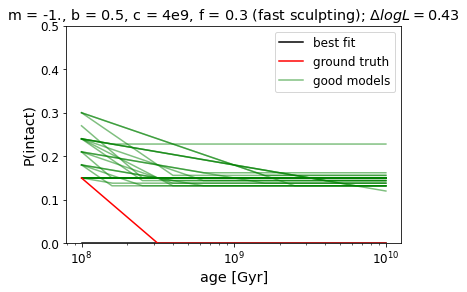

In [185]:
# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

#### Normalizing no-sculpting models, which are fewer than the others

In [30]:
model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.f == 0.1)]

,m,b,c,f,logL
30250,0.0,0.0,1.000000e+08,0.1,-276.863070
30251,0.0,0.0,1.000000e+08,0.1,-276.863070
30252,0.0,0.0,1.000000e+08,0.1,-276.863070
30300,0.0,0.0,1.584893e+08,0.1,-271.592268
30301,0.0,0.0,1.584893e+08,0.1,-271.592268
...,...,...,...,...,...
36201,0.0,1.0,6.309573e+09,0.1,-335.635030
36202,0.0,1.0,6.309573e+09,0.1,-335.635030
36250,0.0,1.0,1.000000e+10,0.1,-332.059695
36251,0.0,1.0,1.000000e+10,0.1,-332.059695


Ope! Looks like I've lost a few differing cutoff timescale files for the case of no sculpting. Fortunately, this edge case means that the logL should be the same regardless of cutoff time. 

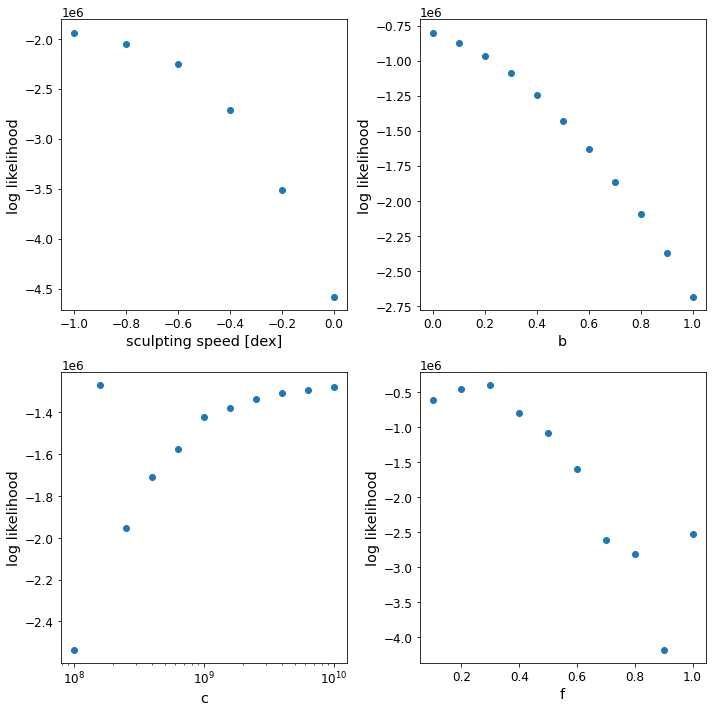

In [32]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

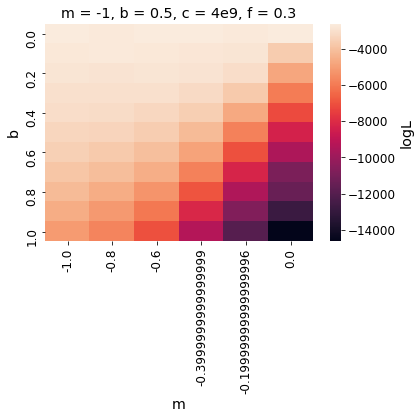

In [33]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

In [34]:
piv

m,-1.0,-0.8,-0.6,-0.4,-0.2,0.0
b,,,,,,
0.0,-2649.934111,-2704.753190,-2632.350792,-2657.005839,-2711.639772,-2657.940952
0.1,-2749.909286,-2680.635465,-2757.914842,-2773.631842,-2841.760153,-3660.976296
0.2,-2861.673762,-2885.096254,-2856.951410,-2909.054922,-3095.593939,-4751.362645
0.3,-2979.304046,-2989.071961,-3005.338446,-3159.418417,-3695.695812,-5933.246537
0.4,-3080.652676,-3136.029843,-3268.964012,-3524.232233,-4675.517010,-7158.009496
0.5,-3293.167656,-3382.951232,-3617.476782,-4163.447304,-5804.905745,-8353.794136
0.6,-3509.819421,-3711.553268,-4026.255073,-4877.444818,-7014.908184,-9509.512440
0.7,-3826.543095,-4084.676091,-4540.260640,-5806.813419,-8227.789013,-10846.967932
0.8,-4151.930809,-4584.181091,-5294.015567,-6926.490019,-9455.767917,-11413.150642


In [35]:
model_logLs.loc[model_logLs.f == 0.3].groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL')

c    f         logL
m    b                                  
-1.0 0.0  2.692617e+10  3.3  -146.408332
     0.1  2.692617e+10  3.3  -177.369264
     0.2  2.692617e+10  3.3  -217.259840
     0.3  2.692617e+10  3.3  -266.159528
     0.4  2.692617e+10  3.3  -316.002271
...                ...  ...          ...
 0.0 0.6  2.692617e+10  3.3 -3112.789403
     0.7  2.692617e+10  3.3 -3731.431045
     0.8  2.692617e+10  3.3 -4213.381086
     0.9  2.692617e+10  3.3 -4815.177203
     1.0  2.692617e+10  3.3 -5557.031939

[66 rows x 3 columns]

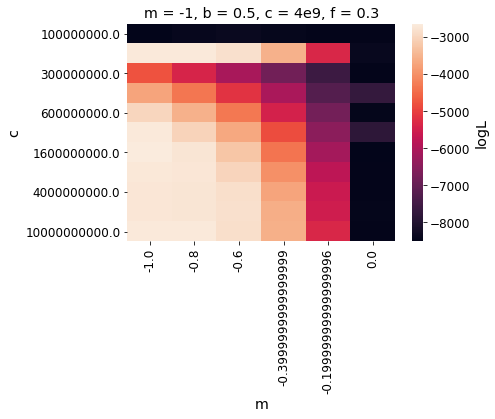

In [37]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(-8), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

It looks like we recover a cutoff time of 2.5 Gyrs instead of 4 Gyrs, as well as {m=0, b=0.5} instead of {m=-1, b=0.5}, although the latter is a close one, and in general the 1D posteriors show that m=0 is generally bad.

#### Model 3: m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)


Before we proceed, let's take a detour to check that the transit multiplicity yields for different models are different in the ways that we expect. For example, a model with more sculpting and/or fewer initially intact systems should have fewer multis.

In [107]:
tm_fiducial = truth.loc[(truth.ms == -0.6) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

3902    [676.5, 162.9, 71.1, 29.7, 7.199999999999999, ...
Name: transit_multiplicities, dtype: object

In [108]:
test_recovery = recovery.loc[(recovery.ms == -0.6) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities

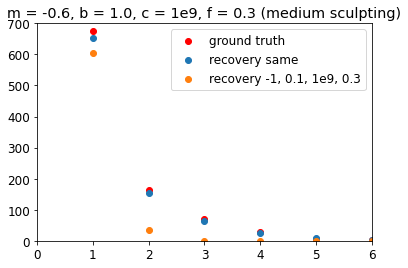

In [72]:
plt.scatter(np.arange(len(tm_fiducial[3902])), tm_fiducial[3902], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[117060].transit_multiplicities)), recovery.iloc[117060].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)')
plt.legend()
plt.show()

Both in count and relative to singles, there are fewer multis represented by the orange dots than the blue/red dots. Anyway, let's continue to check out injection-recovery for medium sculpting models.

In [ ]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep best logL for each model
                    best_logL = np.max(logLs)
                    best_arg = np.argmax(logLs)
                    all_logLs.append(best_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[best_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

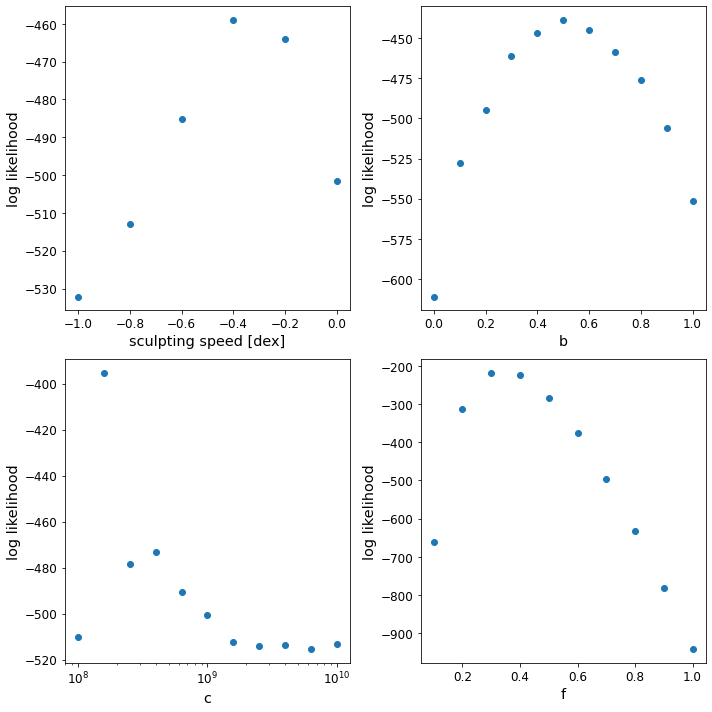

In [118]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

It seems like no matter the ground truth, I always favor the second cutoff threshold. Why is that? This subset of models has the same number of records (eg. no dropped data) and similar mins and maxes to adjacent models (ie. the subsequent cutoff threshold of 2.5e8 yrs). So, what gives? 

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                                                 tm        logL  
10                [210.4, 14.0, 0.0, 0.0, 0.0, 0.0] -900.491017  
11                [420.8, 28.0, 0.0, 0.0, 0.0, 0.0] -543.063274  
12                [612.0, 44.1, 0.0, 0.0, 0.0, 0.0] -422.965359  
13  [816.0, 58.800000000000004, 0.0, 0.0, 0.0, 0.0] -400.185027  
14                [981.0, 67.0, 0.0, 0.0, 0.0, 0.0] -427.535350  


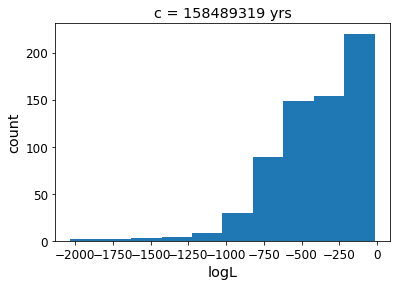

      m    b            c    f                                 tm        logL
20 -1.0  0.0  251188643.0  0.1  [210.3, 14.5, 0.0, 0.0, 0.0, 0.0] -895.496248
21 -1.0  0.0  251188643.0  0.2  [420.6, 29.0, 0.0, 0.0, 0.0, 0.0] -538.468505
22 -1.0  0.0  251188643.0  0.3  [630.9, 43.5, 0.0, 0.0, 0.0, 0.0] -422.921093
23 -1.0  0.0  251188643.0  0.4  [841.2, 58.0, 0.0, 0.0, 0.0, 0.0] -406.240761
24 -1.0  0.0  251188643.0  0.5  [959.0, 60.5, 0.0, 0.0, 0.0, 0.0] -431.003130


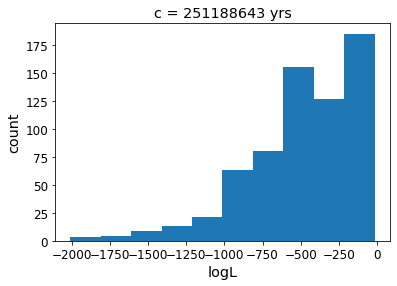

In [144]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


The former distribution does seem to have a shorter tail than the latter. Let's revisit this for other ground truths.

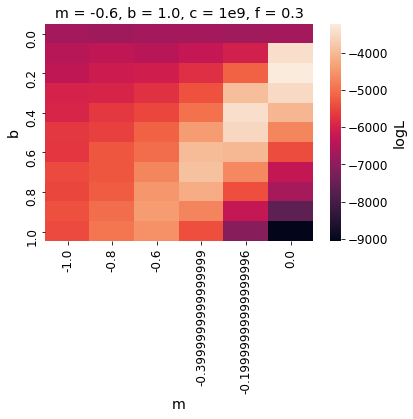

In [145]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
plt.show()

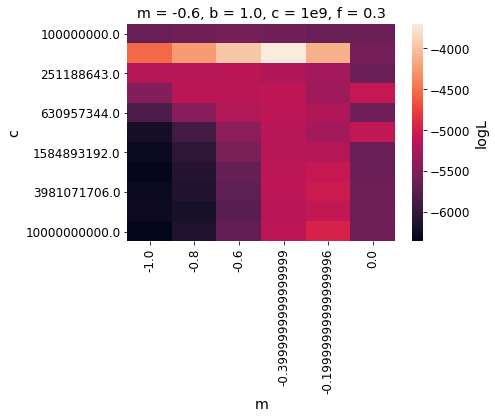

In [146]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
plt.show()

1D posteriors show that I can recover m and c, but not quite f and definitely not b. 2D posteriors corroborate this for m and b, and they suggest that there are fast sculpting models with even shorter cutoff times that are also favored. 

Identify best and good models

In [111]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -0.6) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f                                    tm  \
2002 -0.8  0.7  251188643.0  0.3  [656.4, 159.9, 72.0, 30.9, 7.8, 0.0]   

           logL  
2002 -15.900818  
Ground truth:          m    b             c    f  \
3572 -0.6  1.0  1.000000e+09  0.3   

                                                     tm       logL  
3572  [656.6999999999999, 165.29999999999998, 66.6, ... -16.085823  
Some models between best model and ground truth: 
        m    b             c    f  \
2002 -0.8  0.7  2.511886e+08  0.3   
3572 -0.6  1.0  1.000000e+09  0.3   
4192 -0.4  0.5  1.584893e+08  0.3   
4442 -0.4  0.7  6.309573e+08  0.3   
5422 -0.2  0.5  3.981072e+08  0.3   

                                                     tm       logL  
2002               [656.4, 159.9, 72.0, 30.9, 7.8, 0.0] -15.900818  
3572  [656.6999999999999, 165.29999999999998, 66.6, ... -16.085823  
4192  [664.1999999999999, 169.5, 72.6, 30.5999999999... -15.925064  
4442  [650.4, 159.2999999

Plot these models

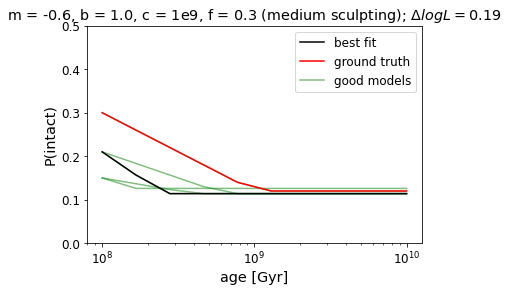

In [113]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting); $\Delta logL = {np.round(delta_logL, 2)}$')
plt.legend()
plt.show()

#### Model 4: m = 0, b = 0.5, c = 1e9, f = 0.3 (no sculpting)


In [147]:
tm_fiducial = truth.loc[(truth.ms == 0.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

7262    [658.8, 183.0, 85.2, 38.1, 11.4, 2.1]
Name: transit_multiplicities, dtype: object

In [150]:
test_recovery = recovery.loc[(recovery.ms == 0.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)]
#test_recovery

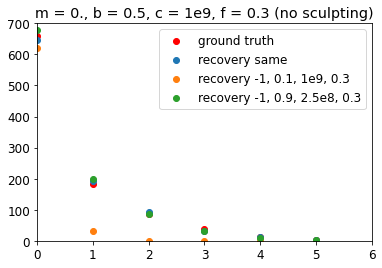

In [151]:
plt.scatter(np.arange(len(tm_fiducial[7262])), tm_fiducial[7262], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[217860].transit_multiplicities)), recovery.iloc[217860].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[33360].transit_multiplicities)), recovery.iloc[33360].transit_multiplicities, label='recovery -1, 0.9, 2.5e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting)')
plt.legend()
plt.show()

In [ ]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep best logL for each model
                    best_logL = np.max(logLs)
                    best_arg = np.argmax(logLs)
                    all_logLs.append(best_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[best_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

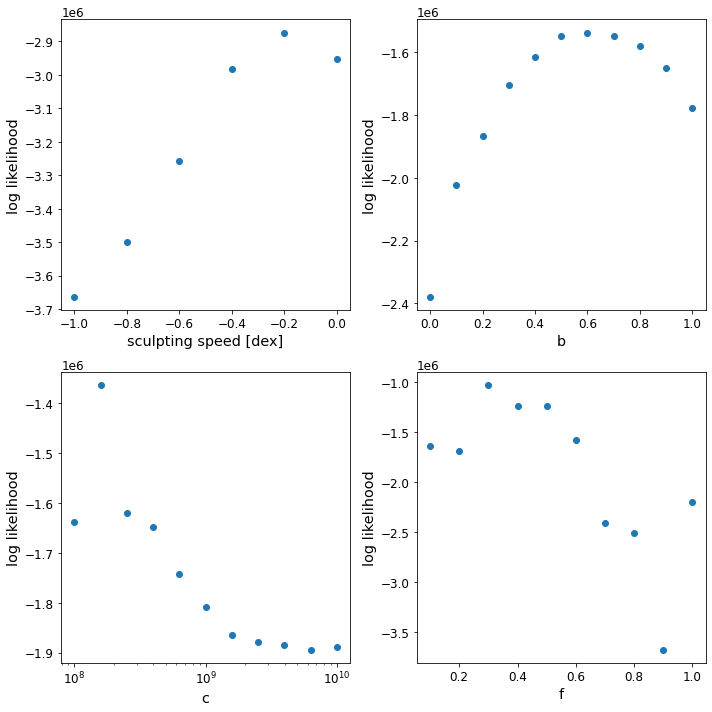

In [93]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

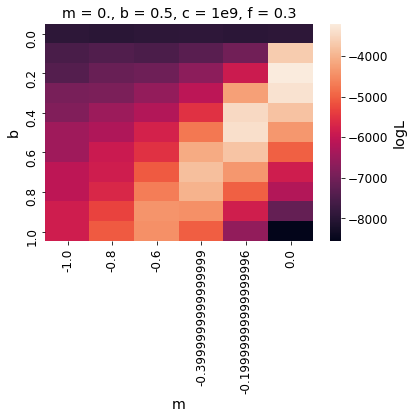

In [94]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3')
plt.show()

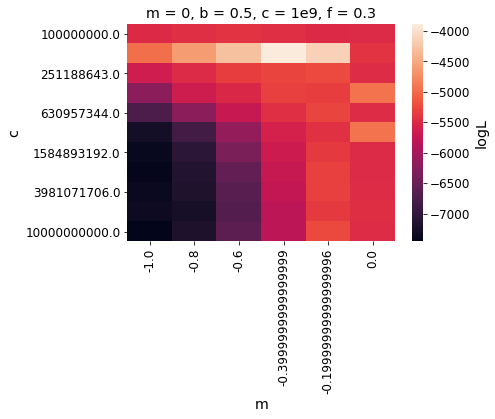

In [95]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0, b = 0.5, c = 1e9, f = 0.3')
plt.show()

We totally miss the mark on recovering the lack of sculpting in the fake ground truth. We do recover b and f, and of course c is not a sensible variable in the case of no sculpting. 

Identify best and good models

In [96]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.logL)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:           m    b            c    f       logL
10559 -0.8  0.8  251188643.0  0.3 -22.248121
10560 -0.8  0.8  251188643.0  0.3 -22.248121
10561 -0.8  0.8  251188643.0  0.3 -22.248121
10562 -0.8  0.8  251188643.0  0.3 -22.248121
10563 -0.8  0.8  251188643.0  0.3 -22.248121
Ground truth:  33259   -22.677888
33260   -22.677888
33261   -22.677888
33262   -22.677888
33263   -22.677888
Name: logL, dtype: float64
Some models between best model and ground truth: 
        m    b            c    f       logL
2759 -1.0  0.5  100000000.0  0.3 -22.626446
2760 -1.0  0.5  100000000.0  0.3 -22.626446
2761 -1.0  0.5  100000000.0  0.3 -22.626446
2762 -1.0  0.5  100000000.0  0.3 -22.626446
2763 -1.0  0.5  100000000.0  0.3 -22.626446


In [103]:
good_models

,m,b,c,f,logL
2759,-1.0,0.5,1.000000e+08,0.3,-22.626446
3909,-1.0,0.7,1.584893e+08,0.3,-22.508455
5059,-1.0,0.9,2.511886e+08,0.3,-22.541086
8809,-0.8,0.5,1.000000e+08,0.3,-22.523355
9409,-0.8,0.6,1.584893e+08,0.3,-22.655002
10559,-0.8,0.8,2.511886e+08,0.3,-22.248121
11709,-0.8,1.0,3.981072e+08,0.3,-22.622312
14859,-0.6,0.5,1.000000e+08,0.3,-22.325124
16659,-0.6,0.8,3.981072e+08,0.3,-22.498534
20909,-0.4,0.5,1.000000e+08,0.3,-22.322109


Plot these models

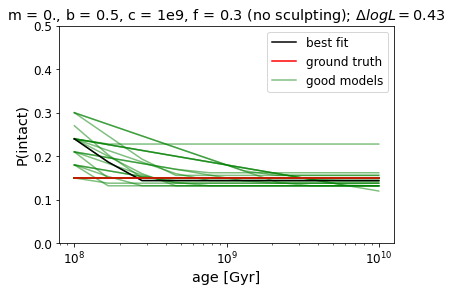

In [97]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

In [114]:
model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL].head(n=20)

,m,b,c,f,logL
2759,-1.0,0.5,100000000.0,0.3,-22.626446
2760,-1.0,0.5,100000000.0,0.3,-22.626446
2761,-1.0,0.5,100000000.0,0.3,-22.626446
2762,-1.0,0.5,100000000.0,0.3,-22.626446
2763,-1.0,0.5,100000000.0,0.3,-22.626446
3909,-1.0,0.7,158489319.0,0.3,-22.508455
3910,-1.0,0.7,158489319.0,0.3,-22.508455
3911,-1.0,0.7,158489319.0,0.3,-22.508455
3912,-1.0,0.7,158489319.0,0.3,-22.508455
3913,-1.0,0.7,158489319.0,0.3,-22.508455
